# Report: Triplet Classification

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

import multiprocessing as mp
from functools import partial

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

import pandas as pd
import seaborn as sns
import ipywidgets as widgets

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')
sys.path.append('../..')

# Local imports
%matplotlib inline
from gnn_pytorch.trainers import get_trainer
# from debug_utils import *
from trackml.score import score_event


# Local imports
from trainers import get_trainer
from data_utils import *
from construction_report_utils import *

In [2]:
from annoy import AnnoyIndex
import random

## Introduction

We will quickly examine an event with all data included from Kaggle. This is event number 9999, the last event in the whole dataset. Chosen because we will run classification on it later and therefore it shouldn't be in the training set of earlier events.

In [115]:
event_file = '/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009999'
hits, particles, truth = trackml.dataset.load_event(
        event_file, parts=['hits', 'particles', 'truth'])

We will leave noise hits in for this intro:

In [116]:
hits = hits_of_interest(hits, truth)

We now have a hit list that has cylindrical co-ordinates, and...

## ANN Hashing

In [4]:
## Template for ANN Hashing
f = 40
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(1000):
    v = [random.gauss(0, 1) for z in range(f)]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 10)) # will find the 1000 nearest neighbors

[0, 859, 420, 976, 552, 627, 929, 476, 291, 419]


In [11]:
hits

hit_id            x          y            z  layer            r  \
0       14601   -30.911800  -8.346660  -427.362000      0    32.018841   
1       14602   -31.038500  -7.984280  -453.641998      0    32.048981   
2       14603   -34.239899   1.172190  -437.119995      0    34.259956   
3       14604   -34.185799   1.017230  -478.709015      0    34.200932   
4       14605   -33.653801  -0.504298  -438.028015      0    33.657578   
...       ...          ...        ...          ...    ...          ...   
56577  101098 -1023.280029   9.490620  1013.799988      9  1023.324036   
56578  101099 -1021.390015  20.471600  1069.339966      9  1021.595154   
56579  101100 -1020.299988  26.815201  1035.400024      9  1020.652283   
56580  101101 -1022.789978  12.387900  1024.599976      9  1022.864990   
56581  101102 -1020.020020  28.411699   992.200012      9  1020.415649   

            phi         particle_id             pt  
0     -2.877867                   0  160838.843750  
1     -2.889813                   0  145287.031250  
2      3.107371  725079677462388738       0.157408  
3      3.111845  238693048010149889       0.401955  
4     -3.126609                   0  613782.625000  
...         ...                 ...            ...  
56577  3.132318                   0  742832.625000  
56578  3.121552  261215512896208896       0.420532  
56579  3.115317                   0  739663.625000  
56580  3.129481                   0  476814.343750  
56581  3.113746                   0  951226.250000  

[56582 rows x 9 columns]

In [19]:
for hit in hits.itertuples():
    print(hit[6:8])

(32.01884078979492, -2.877866506576538)
(32.048980712890625, -2.8898134231567383)
(34.25995635986328, 3.1073713302612305)
(34.200931549072266, 3.1118454933166504)
(33.65757751464844, -3.1266088485717773)
(32.48479080200195, -2.9895825386047363)
(32.299320220947266, -2.562991142272949)
(33.71958541870117, -2.7393901348114014)
(31.968976974487305, -2.0663161277770996)
(32.77433776855469, -1.8540191650390625)
(32.01313400268555, -1.5570290088653564)
(32.01643371582031, -1.6987260580062866)
(31.95472526550293, -1.2700227499008179)
(32.024662017822266, -1.309510350227356)
(32.368282318115234, -1.3983511924743652)
(34.351314544677734, -1.219103455543518)
(31.967308044433594, -0.4037063717842102)
(31.937379837036133, -0.462453156709671)
(33.86534118652344, -0.39566677808761597)
(32.111053466796875, 0.04856155440211296)
(32.545867919921875, -0.2504955232143402)
(33.434181213378906, -0.3569944202899933)
(32.05955505371094, 0.4247048497200012)
(31.968364715576172, 0.38239535689353943)
(31.936328

(33.31502151489258, 2.010952949523926)
(31.938640594482422, 2.3160691261291504)
(32.501014709472656, 2.112851619720459)
(33.09192657470703, 2.0345802307128906)
(32.0887451171875, 2.3979427814483643)
(32.00675582885742, 2.367088556289673)
(34.090118408203125, 1.9423223733901978)
(32.10273742675781, 2.1974096298217773)
(31.964889526367188, 2.3434324264526367)
(33.51279067993164, 1.9917216300964355)
(31.99056053161621, 2.3590481281280518)
(32.39750289916992, 2.1305665969848633)
(33.12881088256836, 2.0305142402648926)
(32.11952590942383, 2.407240390777588)
(33.097206115722656, 2.03399395942688)
(31.938566207885742, 2.283879041671753)
(31.935022354125977, 2.30588436126709)
(31.965465545654297, 2.255784749984741)
(32.00422286987305, 2.2337965965270996)
(32.86901092529297, 2.060809850692749)
(33.069725036621094, 2.037064790725708)
(33.53218460083008, 1.9899080991744995)
(33.093135833740234, 2.0344505310058594)
(33.02602005004883, 2.0420284271240234)
(31.995738983154297, 2.2379603385925293)
(3

(31.496580123901367, -2.865518569946289)
(31.442625045776367, -2.790773391723633)
(31.646255493164062, -2.6908390522003174)
(32.41670608520508, -3.0514185428619385)
(31.85639762878418, -2.967235565185547)
(32.51121139526367, -3.0627424716949463)
(33.563533782958984, 3.1202614307403564)
(31.564897537231445, -2.7160210609436035)
(32.52235412597656, -3.0640382766723633)
(32.974090576171875, -3.1115400791168213)
(31.569395065307617, -2.7144434452056885)
(32.41551971435547, -3.0512754917144775)
(31.824058532714844, -2.9608922004699707)
(31.63425636291504, -2.916297435760498)
(31.45709800720215, -2.771653175354004)
(31.683202743530273, -2.9293856620788574)
(31.636795043945312, -2.693466901779175)
(32.30149459838867, -3.0368001461029053)
(33.304298400878906, -3.1414756774902344)
(31.46102523803711, -2.768129587173462)
(31.47340202331543, -2.758755683898926)
(31.446449279785156, -2.7839624881744385)
(32.23847579956055, -3.0283544063568115)
(31.575790405273438, -2.8982362747192383)
(32.63016128

(71.66875457763672, 1.480906367301941)
(71.32827758789062, 1.5239417552947998)
(72.90829467773438, 1.3862361907958984)
(72.34476470947266, 1.4229944944381714)
(72.13214111328125, 1.4390240907669067)
(72.44503784179688, 1.4159188270568848)
(73.02747344970703, 1.3792592287063599)
(71.7420883178711, 1.4734020233154297)
(72.03509521484375, 1.6432313919067383)
(72.31566619873047, 1.6214522123336792)
(71.73522186279297, 1.6704384088516235)
(73.38417053222656, 1.5559660196304321)
(71.22439575195312, 1.7385814189910889)
(71.06925964355469, 1.7844923734664917)
(73.31778717041016, 1.559494972229004)
(71.38753509521484, 1.7114055156707764)
(71.1142349243164, 1.7657997608184814)
(72.41294860839844, 1.6145000457763672)
(71.92528533935547, 1.6526280641555786)
(71.70886993408203, 1.6731051206588745)
(71.14012145996094, 1.75807523727417)
(71.29635620117188, 1.7254706621170044)
(71.39383697509766, 1.710496425628662)
(71.84617614746094, 1.6597682237625122)
(71.31664276123047, 1.7221447229385376)
(72.105

(71.19039154052734, 2.334761142730713)
(71.16126251220703, 2.3415980339050293)
(71.07752227783203, 2.3692002296447754)
(71.41206359863281, 2.493349075317383)
(71.09087371826172, 2.5596306324005127)
(72.56446838378906, 2.389570713043213)
(72.86732482910156, 2.3704395294189453)
(72.5380630493164, 2.3913300037384033)
(72.02284240722656, 2.429652690887451)
(71.25996398925781, 2.713573932647705)
(72.21459197998047, 2.6107287406921387)
(71.88214874267578, 2.6382248401641846)
(71.61807250976562, 2.6644561290740967)
(72.9768295288086, 2.5602939128875732)
(71.17784881591797, 2.7303154468536377)
(72.57208251953125, 2.5854132175445557)
(71.22782135009766, 2.9160046577453613)
(72.49063110351562, 2.78722882270813)
(72.06336975097656, 2.819000005722046)
(71.97291564941406, 2.8265795707702637)
(71.72465515136719, 2.849594831466675)
(71.1011962890625, 2.9483962059020996)
(72.1912841796875, 2.8088631629943848)
(72.37316131591797, 2.991760492324829)
(72.52232360839844, 2.9814352989196777)
(72.1461563110

(115.65252685546875, 1.7581350803375244)
(115.59001922607422, 1.8830925226211548)
(115.31324005126953, 1.9029892683029175)
(116.31238555908203, 1.8419376611709595)
(116.29312896728516, 1.8429138660430908)
(115.53862762451172, 1.8864856958389282)
(115.15635681152344, 1.9160740375518799)
(115.897705078125, 1.8640754222869873)
(115.32097625732422, 1.9023324251174927)
(116.26588439941406, 1.8442786931991577)
(115.93988800048828, 1.9824999570846558)
(115.96459197998047, 1.981153964996338)
(114.9770278930664, 2.0546252727508545)
(115.0726547241211, 2.044755458831787)
(115.67711639404297, 1.9982497692108154)
(115.56977081298828, 2.1260719299316406)
(116.97412872314453, 2.053463935852051)
(115.30500793457031, 2.1452789306640625)
(115.62571716308594, 2.1223788261413574)
(115.13777923583984, 2.1594362258911133)
(117.1629867553711, 2.0457067489624023)
(116.07046508789062, 2.096149444580078)
(115.38130950927734, 2.139404535293579)
(116.42886352539062, 2.0779147148132324)
(115.39553833007812, 2.138

(116.33353424072266, -1.3007036447525024)
(116.78096771240234, -1.3215056657791138)
(115.79896545410156, -1.271704077720642)
(116.96682739257812, -1.3294936418533325)
(115.36540222167969, -1.121824860572815)
(115.70165252685547, -1.1448814868927002)
(115.3481674194336, -1.1205188035964966)
(115.54812622070312, -1.1348702907562256)
(115.88079071044922, -1.1556593179702759)
(115.2499771118164, -1.1127147674560547)
(116.23273468017578, -1.174804449081421)
(116.73847961425781, -1.1988003253936768)
(116.47826385498047, -1.1868751049041748)
(116.39478302001953, -1.0620489120483398)
(115.33431243896484, -0.9986041784286499)
(116.25251770019531, -1.0549808740615845)
(115.64866638183594, -1.020696759223938)
(115.21726989746094, -0.9891396164894104)
(115.61579132080078, -1.0185648202896118)
(115.178955078125, -0.9858405590057373)
(116.01937866210938, -1.0426859855651855)
(115.52540588378906, -1.0125148296356201)
(115.77849578857422, -1.0287951231002808)
(115.14149475097656, -0.8616665601730347)


(172.32044982910156, -2.478684663772583)
(172.61044311523438, -2.4886748790740967)
(172.5283966064453, -2.485914707183838)
(172.17935180664062, -2.3930530548095703)
(171.29661560058594, -2.3561201095581055)
(171.30157470703125, -2.3563389778137207)
(171.20849609375, -2.351771116256714)
(170.90953063964844, -2.3355355262756348)
(172.14297485351562, -2.3111510276794434)
(170.8601531982422, -2.251988649368286)
(172.86595153808594, -2.3358919620513916)
(172.3698272705078, -2.319314956665039)
(171.037841796875, -2.262230396270752)
(170.95260620117188, -2.257458448410034)
(171.08624267578125, -2.184302568435669)
(171.1223907470703, -2.1861934661865234)
(172.78253173828125, -2.2526626586914062)
(170.79888916015625, -2.1676931381225586)
(172.21348571777344, -2.23317289352417)
(172.3448028564453, -2.2379000186920166)
(173.05221557617188, -2.2611398696899414)
(171.7700653076172, -2.2160520553588867)
(170.82957458496094, -2.0890047550201416)
(171.97605895996094, -2.143718719482422)
(172.634628295

(172.03384399414062, 0.21059641242027283)
(171.7930908203125, 0.3022806644439697)
(172.76930236816406, 0.26200801134109497)
(171.86497497558594, 0.37940213084220886)
(172.03744506835938, 0.3715435564517975)
(172.90283203125, 0.33784219622612)
(171.6352996826172, 0.4712795317173004)
(171.38116455078125, 0.56595379114151)
(172.31080627441406, 0.5211157202720642)
(172.30831909179688, 0.5212303996086121)
(173.4433135986328, 0.561698853969574)
(171.48086547851562, 0.6407229900360107)
(172.6934051513672, 0.5869746208190918)
(172.24798583984375, 0.6042476296424866)
(172.5270538330078, 0.5931776762008667)
(172.49583435058594, 0.5943706035614014)
(173.59999084472656, 0.6374377012252808)
(172.43821716308594, 0.6771844625473022)
(171.7413330078125, 0.7881402969360352)
(171.78228759765625, 0.9472194314002991)
(173.02029418945312, 0.8976747393608093)
(172.1989288330078, 0.9284949898719788)
(173.052734375, 0.8965969085693359)
(171.9866943359375, 0.9376845955848694)
(172.88490295410156, 0.98291945457

(264.68798828125, 1.2436290979385376)
(263.2043762207031, 1.2161610126495361)
(262.16845703125, 1.194125771522522)
(259.89642333984375, 1.1294186115264893)
(265.93212890625, 1.2640538215637207)
(259.10809326171875, 1.0929607152938843)
(261.21551513671875, 1.1707136631011963)
(259.7701110839844, 1.1245168447494507)
(264.9293518066406, 1.247758388519287)
(259.0226745605469, 1.2446974515914917)
(260.235595703125, 1.298579216003418)
(263.8852844238281, 1.3863447904586792)
(263.03411865234375, 1.3698047399520874)
(263.9891052246094, 1.3882744312286377)
(259.6500549316406, 1.2766886949539185)
(259.892578125, 1.2863450050354004)
(259.35205078125, 1.2631727457046509)
(259.45123291015625, 1.267937421798706)
(262.3020324707031, 1.3542139530181885)
(260.1945495605469, 1.297203779220581)
(259.632080078125, 1.2759218215942383)
(259.86871337890625, 1.285426378250122)
(261.5377502441406, 1.3361215591430664)
(260.08905029296875, 1.450615644454956)
(260.662353515625, 1.4692285060882568)
(264.5093383789

(359.70233154296875, -0.48419809341430664)
(358.2496032714844, -0.509596049785614)
(356.50335693359375, -0.43595224618911743)
(357.4858703613281, -0.4128102660179138)
(362.4429626464844, -0.2204187512397766)
(361.1624450683594, -0.2377507984638214)
(360.04754638671875, -0.25432515144348145)
(357.4997253417969, -0.1881134957075119)
(355.93585205078125, -0.227644145488739)
(361.1474914550781, -0.12576813995838165)
(361.826904296875, -0.11636407673358917)
(356.042724609375, -0.22439956665039062)
(356.3742980957031, -0.10279665887355804)
(360.0540466308594, -0.02981633134186268)
(358.1430358886719, -0.0628458708524704)
(358.8680419921875, 0.06273968517780304)
(357.9880676269531, 0.15853102505207062)
(355.713134765625, 0.10178788751363754)
(359.0854187011719, 0.29091769456863403)
(361.0050964355469, 0.32100072503089905)
(356.9992370605469, 0.24950124323368073)
(355.9268798828125, 0.2208753228187561)
(361.9339294433594, 0.4460798501968384)
(355.93218994140625, 0.33324378728866577)
(358.02600

(358.210693359375, -0.173738032579422)
(357.3268737792969, -0.07965083420276642)
(358.962158203125, -0.047809042036533356)
(359.2499694824219, -0.04286128282546997)
(361.63818359375, -0.0067288754507899284)
(356.88702392578125, -0.08976877480745316)
(362.5010681152344, 0.004736196715384722)
(360.3316345214844, -0.025554105639457703)
(360.2449645996094, -0.026864923536777496)
(358.9052734375, -0.04879964888095856)
(355.77069091796875, -0.12070699781179428)
(359.1787414550781, -0.0440700463950634)
(358.059814453125, -0.06446768343448639)
(361.88604736328125, -0.0033702384680509567)
(360.5194396972656, 0.08948348462581635)
(359.9424743652344, 0.08063299208879471)
(361.9015808105469, 0.10904612392187119)
(355.7572937011719, -0.008955242112278938)
(357.7561950683594, 0.041644301265478134)
(355.9855041503906, -0.0017226270865648985)
(360.8399963378906, 0.09420645982027054)
(356.11480712890625, 0.0021248976700007915)
(356.15179443359375, 0.0031869332306087017)
(357.17327880859375, 0.029105110

(503.30389404296875, -0.09872779250144958)
(504.7876281738281, -0.08256648480892181)
(504.7206115722656, -0.08326555788516998)
(502.8717041015625, -0.10374322533607483)
(501.08453369140625, -0.1264151632785797)
(501.1596374511719, -0.044834669679403305)
(502.199462890625, -0.03133172169327736)
(500.41644287109375, -0.05535378307104111)
(499.4848937988281, -0.06987617909908295)
(500.717041015625, -0.050999995321035385)
(505.131591796875, 0.0015266562113538384)
(499.1376953125, 0.00479013891890645)
(503.4011535644531, 0.06348687410354614)
(502.0325927734375, 0.04713451489806175)
(500.9097595214844, 0.03226889297366142)
(498.7159729003906, -0.0028194442857056856)
(499.8636779785156, 0.0973481833934784)
(499.8636779785156, 0.0973481833934784)
(502.1972961425781, 0.1297493278980255)
(502.3885803222656, 0.13210786879062653)
(505.41998291015625, 0.16554738581180573)
(505.4512634277344, 0.16585779190063477)
(499.2115173339844, 0.08661729097366333)
(498.834716796875, 0.16048036515712738)
(498.8

(498.6098937988281, 0.686152994632721)
(500.0083923339844, 0.784054696559906)
(496.7793273925781, 0.7402772903442383)
(500.1408996582031, 0.7856045961380005)
(496.69183349609375, 0.7388656139373779)
(499.1698303222656, 0.7738897204399109)
(500.2467346191406, 0.7868244051933289)
(502.16094970703125, 0.8075864911079407)
(496.8066101074219, 0.740704357624054)
(496.0812683105469, 0.8090874552726746)
(498.0065612792969, 0.8391094207763672)
(495.86083984375, 0.8051027655601501)
(497.62213134765625, 0.8336461186408997)
(499.8792419433594, 0.8630815744400024)
(500.80596923828125, 0.954268217086792)
(502.2109375, 0.9692022204399109)
(497.49261474609375, 0.9123147130012512)
(497.5255126953125, 1.0739003419876099)
(498.84088134765625, 1.0919334888458252)
(497.3262939453125, 1.0709519386291504)
(495.6128234863281, 1.0420979261398315)
(497.99334716796875, 1.0805835723876953)
(499.2984313964844, 1.1782668828964233)
(502.1689758300781, 1.210432767868042)
(500.3936462402344, 1.1912875175476074)
(501.4

(664.6558837890625, 1.1682977676391602)
(661.8090209960938, 1.1426604986190796)
(661.9501342773438, 1.2056339979171753)
(663.1883544921875, 1.2171947956085205)
(659.3759765625, 1.178117275238037)
(661.5911865234375, 1.2021085023880005)
(659.309814453125, 1.1773335933685303)
(659.4414672851562, 1.3020985126495361)
(662.6348266601562, 1.396934986114502)
(662.2608642578125, 1.4550167322158813)
(661.537841796875, 1.4479701519012451)
(662.0927734375, 1.4534058570861816)
(662.5523071289062, 1.4577597379684448)
(659.5884399414062, 1.4270225763320923)
(664.663818359375, 1.4763562679290771)
(665.0874633789062, 1.5414478778839111)
(665.0874633789062, 1.5414478778839111)
(660.0330810546875, 1.4936907291412354)
(663.5980224609375, 1.5904407501220703)
(663.1690063476562, 1.586616039276123)
(660.0000610351562, 1.5549302101135254)
(659.8648681640625, 1.5534015893936157)
(658.7376708984375, 1.5398855209350586)
(665.0287475585938, 1.6025745868682861)
(660.9957275390625, 1.5656652450561523)
(659.2396240

(662.4334716796875, -1.3769463300704956)
(659.9421997070312, -1.279323697090149)
(663.6669311523438, -1.2425488233566284)
(660.0884399414062, -1.277683138847351)
(661.7330932617188, -1.2604811191558838)
(661.0602416992188, -1.2672691345214844)
(661.4747924804688, -1.2630459070205688)
(662.4474487304688, -1.2536078691482544)
(661.7064208984375, -1.260750651359558)
(663.7179565429688, -1.2421038150787354)
(659.804443359375, -1.219286561012268)
(658.8604736328125, -1.2305653095245361)
(660.3206176757812, -1.1519215106964111)
(662.0911254882812, -1.1338019371032715)
(660.6307373046875, -1.0253748893737793)
(663.0540161132812, -0.9400137066841125)
(661.280029296875, -0.9570161700248718)
(659.9522705078125, -0.9712039828300476)
(663.6213989257812, -0.8733482360839844)
(663.161865234375, -0.8774369955062866)
(664.2061157226562, -0.8682904243469238)
(664.3878173828125, -0.8051496744155884)
(660.3396606445312, -0.843711793422699)
(658.5292358398438, -0.8035834431648254)
(660.3575439453125, -0.7

(817.0593872070312, -2.132735252380371)
(818.0267944335938, -2.1244523525238037)
(818.2025146484375, -2.07064151763916)
(816.1395263671875, -2.036389112472534)
(820.4140625, -2.001136064529419)
(820.3257446289062, -2.001786470413208)
(820.0818481445312, -2.0035910606384277)
(815.8555908203125, -1.9867277145385742)
(818.157958984375, -1.9662851095199585)
(816.8051147460938, -1.925551414489746)
(821.6557006835938, -1.8875561952590942)
(818.5851440429688, -1.9104443788528442)
(815.320556640625, -1.8872649669647217)
(821.6143798828125, -1.835484266281128)
(817.7664184570312, -1.81247079372406)
(817.6204223632812, -1.813705325126648)
(820.7908325195312, -1.736596941947937)
(821.8853149414062, -1.6765352487564087)
(819.7644653320312, -1.6394550800323486)
(818.1491088867188, -1.652198076248169)
(820.3251342773438, -1.5829070806503296)
(817.8875732421875, -1.6020151376724243)
(821.3571166992188, -1.523124098777771)
(815.3722534179688, -1.5725938081741333)
(817.4763793945312, -1.553141474723816

(1022.0126953125, 0.39598095417022705)
(1020.5567626953125, 0.3864516019821167)
(1020.3680419921875, 0.42650875449180603)
(1024.54052734375, 0.4525392949581146)
(1019.1129760742188, 0.5416600704193115)
(1021.1578369140625, 0.5971478223800659)
(1020.7551879882812, 0.6358106732368469)
(1018.9696655273438, 0.6646202802658081)
(1019.322265625, 0.7085239887237549)
(1022.9452514648438, 0.8151447772979736)
(1023.5324096679688, 0.8186756372451782)
(1019.36279296875, 0.7914886474609375)
(1019.7804565429688, 0.8357985019683838)
(1020.6509399414062, 0.8831331729888916)
(1019.8546142578125, 0.8776600956916809)
(1021.0079345703125, 0.9268540740013123)
(1021.477783203125, 0.9299329519271851)
(1020.080078125, 0.9205691814422607)
(1020.3936157226562, 0.9227244257926941)
(1021.6126708984375, 0.9308041930198669)
(1022.9267578125, 0.9803757667541504)
(1023.0314331054688, 1.0223497152328491)
(1021.462646484375, 1.0125099420547485)
(1020.7371215820312, 1.0490615367889404)
(1021.6942138671875, 1.05533742904

(1020.7551879882812, -0.8936488628387451)
(1025.2022705078125, -0.8664860725402832)
(1022.2703247070312, -0.8838341236114502)
(1021.3175048828125, -0.8485919833183289)
(1019.7962036132812, -0.8175544142723083)
(1022.363037109375, -0.8005809187889099)
(1021.6851806640625, -0.8048743009567261)
(1021.4601440429688, -0.7649891972541809)
(1019.5824584960938, -0.7777325510978699)
(1021.3704833984375, -0.7242337465286255)
(1020.0891723632812, -0.7328419089317322)
(1023.8939208984375, -0.66730797290802)
(1020.8765869140625, -0.6861515045166016)
(1022.9840087890625, -0.6314092874526978)
(1019.5252075195312, -0.6541305780410767)
(1023.77587890625, -0.6266649961471558)
(1020.677001953125, -0.6461524963378906)
(1022.79345703125, -0.5498943328857422)
(1024.35009765625, -0.5406394600868225)
(1021.8023681640625, -0.556098997592926)
(1018.3920288085938, -0.5384677052497864)
(1023.8741455078125, -0.502076268196106)
(1018.9463500976562, -0.4929838180541992)
(1021.5402221679688, -0.43377232551574707)
(10

In [117]:
hits = hits[(hits.particle_id != 0) & (hits.pt > 0.5)].reset_index(drop=True)

In [118]:
hits

hit_id           x            y            z  layer            r  \
0       14607  -27.041901   -17.663000  -473.080994      0    32.299320   
1       14658   11.687200   -29.219400  -369.752991      0    31.470049   
2       14668   29.575199    10.669500  -387.214996      0    31.440907   
3       14682  -25.825100    18.830700  -382.362000      0    31.961399   
4       14690  -34.370899     1.546790  -297.743988      0    34.405689   
...       ...         ...          ...          ...    ...          ...   
17800  101058 -126.246002  1010.719971   981.400024      9  1018.573975   
17801  101060 -189.792007  1003.849976   992.200012      9  1021.633850   
17802  101064 -431.739014   926.151001  1013.799988      9  1021.838684   
17803  101079 -809.625977   628.771973   992.200012      9  1025.109009   
17804  101081 -806.768982   622.629028   992.200012      9  1019.089355   

            phi         particle_id        pt  
0     -2.562991  279226612887592962  0.624349  
1     -1.190306  112598443179900928  1.009170  
2      0.346227  779125209453043714  1.628391  
3      2.511561  779125209453039617  0.967194  
4      3.096620   54044776076410880  1.286533  
...         ...                 ...       ...  
17800  1.695060  783638154912464896  1.291671  
17801  1.757655  121599732559642624  0.881492  
17802  2.007011  463876053018869760  0.576631  
17803  2.481271  788133783080534016  0.644814  
17804  2.484312  788133783080534016  0.646137  

[17805 rows x 9 columns]

In [297]:
%%time

## Template for ANN Hashing
f = 3
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for hit in hits.itertuples():
    t.add_item(hit.Index, hit[2:5])

t.build(1) # 10 trees
t.save('test.ann')

# ...

# u = AnnoyIndex(f, 'angular')
# u.load('test.ann') # super fast, will just mmap the file
# print(u.get_nns_by_item(14601, 10)) # will find the 1000 nearest neighbors

CPU times: user 99.4 ms, sys: 0 ns, total: 99.4 ms
Wall time: 98.6 ms


True

In [385]:
layer_5_hits = hits[hits.layer == 5]

In [386]:
layer_5_hits = layer_5_hits[['particle_id']].to_numpy()

In [396]:
hits_np = hits.particle_id.to_numpy()

In [422]:
%%time
bucket_size = 250
total_pids = 0
total_hits = 0
included = 0
target_layer = 5
for i, hit in enumerate(hits_np):
    
    pids = hits_np[hits_np == hit]
    
    nb = t.get_nns_by_item(i, bucket_size)
    
    total_pids += len(pids)
    total_hits += 250
    included += sum(np.isin(hits_np[nb], pids))

CPU times: user 11.6 s, sys: 15.4 ms, total: 11.6 s
Wall time: 11.6 s


In [424]:
%%time
bucket_size = 250
total_pids = 0
total_hits = 0
included = 0
target_layer = 5
for hit in hits[hits.layer == target_layer].itertuples():
    pid = hit.particle_id
    pids = hits[hits.particle_id == pid].particle_id
    
    nb = t.get_nns_by_item(hit.Index, bucket_size)
    nb_hits = hits.iloc[nb]
    
    total_pids += len(pids)
    total_hits += 250
    included += sum(np.isin(nb_hits.particle_id, pids))

CPU times: user 3.95 s, sys: 15.9 ms, total: 3.96 s
Wall time: 3.96 s


In [425]:
print("Efficiency:", included/total_pids, "Purity:", included/total_hits)

Efficiency: 0.9688485586233608 Purity: 0.04020665901262916


In [334]:
hid = 13428
pid = hits.iloc[hid].particle_id
pids = hits[hits.particle_id == pid]

In [335]:
pids

hit_id           x           y            z  layer           r  \
775     16603  -31.932501   -5.427280   -59.686100      0   32.390430   
3611    23216  -70.386200  -13.325500  -141.658997      1   71.636482   
3612    23219  -72.468498  -13.799000  -146.128006      1   73.770561   
3776    23657  -69.903900  -13.213600  -140.621994      1   71.141792   
6020    29242 -112.842003  -23.906300  -233.410995      2  115.346558   
7948    34339 -166.285004  -39.967499  -350.747009      3  171.020767   
7949    34341 -168.192001  -40.603600  -354.964996      3  173.023697   
9946    61179 -250.354996  -72.032501  -539.599976      4  260.511627   
11824   66871 -342.044006 -117.875999  -756.099976      5  361.785645   
11826   66874 -336.739014 -114.862999  -742.799988      5  355.790222   
13428   72106 -464.269012 -199.348999 -1068.400024      6  505.258087   
13429   72107 -459.016998 -195.315002 -1054.000000      6  498.843231   

            phi         particle_id        pt  
775   -2.973240  211670350717517824  0.587545  
3611  -2.954487  211670350717517824  0.584975  
3612  -2.953431  211670350717517824  0.584800  
3776  -2.954772  211670350717517824  0.585457  
6020  -2.932823  211670350717517824  0.583707  
7948  -2.905712  211670350717517824  0.582388  
7949  -2.904713  211670350717517824  0.582404  
9946  -2.861438  211670350717517824  0.580271  
11824 -2.809717  211670350717517824  0.577025  
11826 -2.812865  211670350717517824  0.577379  
13428 -2.736016  211670350717517824  0.572451  
13429 -2.739293  211670350717517824  0.572571

In [339]:
hits[hits.particle_id == 788133783080534016]

hit_id           x           y           z  layer            r  \
2408    20169  -31.158300    5.868850   28.791100      0    31.706200   
4877    26206  -69.634697   14.573500   66.170197      1    71.143364   
4903    26248  -71.741600   15.087800   68.226898      1    73.310974   
7335    32514 -114.121002   26.410900  109.629997      2   117.137260   
9285    38124 -165.703003   42.643902  160.464005      3   171.102264   
11103   64471 -248.600998   75.021797  244.199997      4   259.674255   
12974   70515 -341.173004  120.674004  341.399994      5   361.885651   
12976   70520 -335.967987  117.799004  335.600006      5   356.021210   
14636   76610 -460.950012  198.005997  474.799988      6   501.678467   
14637   76613 -456.119995  194.518005  469.200012      6   495.865601   
15899   81909 -584.986023  305.062988  628.200012      7   659.751526   
16950   95938 -695.672974  434.899994  786.200012      8   820.426025   
17803  101079 -809.625977  628.771973  992.200012      9  1025.109009   
17804  101081 -806.768982  622.629028  992.200012      9  1019.089355   

            phi         particle_id        pt  
2408   2.955418  788133783080534016  0.647358  
4877   2.935285  788133783080534016  0.646451  
4903   2.934306  788133783080534016  0.646466  
7335   2.914168  788133783080534016  0.647430  
9285   2.889707  788133783080534016  0.647466  
11103  2.848507  788133783080534016  0.646957  
12974  2.801623  788133783080534016  0.647415  
12976  2.804361  788133783080534016  0.646663  
14636  2.735865  788133783080534016  0.647313  
14637  2.738484  788133783080534016  0.647976  
15899  2.660903  788133783080534016  0.646411  
16950  2.582886  788133783080534016  0.646982  
17803  2.481271  788133783080534016  0.644814  
17804  2.484312  788133783080534016  0.646137

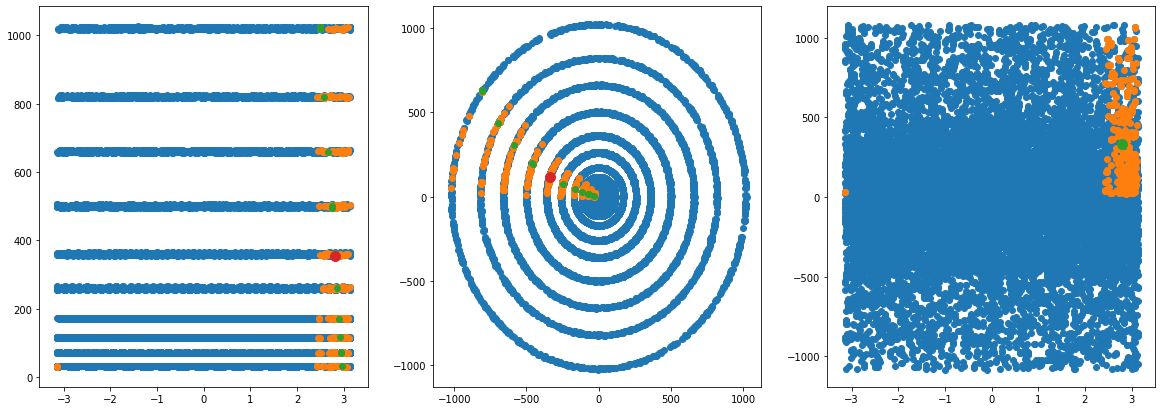

In [340]:
hid = 12976
pid = hits.iloc[hid].particle_id
pids = hits[hits.particle_id == pid]
nb = t.get_nns_by_item(hid, 250)
nb_hits = hits.iloc[nb]
fig, axs = plt.subplots(1,3,figsize=(20,7))
axs[0].scatter(hits.phi, hits.r)
axs[0].scatter(nb_hits.phi, nb_hits.r)
axs[0].scatter(pids.phi, pids.r)
axs[0].scatter(hits.iloc[hid].phi, hits.iloc[hid].r, s=100)
axs[1].scatter(hits.x, hits.y)
axs[1].scatter(nb_hits.x, nb_hits.y)
axs[1].scatter(pids.x, pids.y)
axs[1].scatter(hits.iloc[hid].x, hits.iloc[hid].y, s=100)
axs[2].scatter(hits.phi, hits.z)
axs[2].scatter(nb_hits.phi, nb_hits.z)
axs[2].scatter(hits.iloc[hid].phi, hits.iloc[hid].z, s=100)

In [241]:
%%time

recon = set()
queries = 2000
bucket_size = 50
for i in np.random.choice(np.arange(0,len(hits)), queries, replace = False):
    nbs = t.get_nns_by_item(i, bucket_size)
    recon.update(nbs) 

CPU times: user 21.4 ms, sys: 4.08 ms, total: 25.4 ms
Wall time: 24.8 ms


In [242]:
recon_list = list(recon)
recon_list.sort()

In [243]:
print("Efficiency:", len(recon_list)/len(hits))

Efficiency: 0.9978657680426847


## Meet Brian

Out of the total number of tracks, there are...

In [11]:
len(unique_duplicate_pids)

1386

Low pT tracks with duplicate hits. These look like...

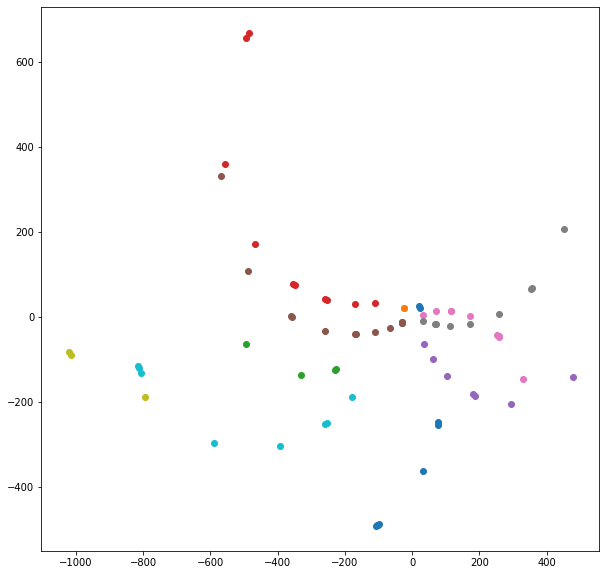

In [12]:
plt.figure(figsize=(10,10))
for pid in unique_duplicate_pids[-10:]:
    pid_hits = hits[hits['particle_id'] == pid]
    plt.scatter(pid_hits.x, pid_hits.y)

Look at that beautiful red track with multiple duplicates and a huge curvature. It has particle ID #846680715692089346 and event ID #9999, but let's call it Brian. Our task will be to classify **all** tracks correctly, but focus on Brian as a tough case.

In [63]:
brian = 846680715692089346

# Graph Construction

## Introduction

We will try multiple methods of constructing a graph from the hit data. For these constructions, we will work with no pT cut or duplicate restriction - all real hits are fair game. However, we **will** remove noise.

In [60]:
# Geometric and physics cuts
pt_min = 0.
phi_slope_max = .001
z0_max = 200

# Graph features and scale
feature_names = ['r', 'phi', 'z']
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

## Heuristic Construction

We load the set of TrackML data, and run the constructor to get training and testing data. Training from the front, testing from the back. For visualisation purposes, we will just look at one test example, event #9999.

In [4]:
HC_input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/"
all_events = os.listdir(HC_input_dir)
all_events = [HC_input_dir + event[:14] for event in all_events]
all_events = list(set(all_events))
all_events.sort()

In [5]:
train_size, test_size = 1, 1
out = display(progress(0, train_size), display_id=True)
HC_train_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale, n_phi_sections, iter, train_size, out) for (event_file, iter) in zip(all_events[:train_size], range(train_size))]
HC_train_dataset = [datapoint for dataset in HC_train_dataset for datapoint in dataset]
out = display(progress(0, test_size), display_id=True)
HC_test_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale, n_phi_sections, iter, test_size, out) for (event_file, iter) in zip(all_events[-test_size:], range(test_size))]
HC_test_dataset = [datapoint for dataset in HC_test_dataset for datapoint in dataset]
HC_train_loader = DataLoader(HC_train_dataset, batch_size=2, shuffle=True)
HC_test_loader = DataLoader(HC_test_dataset, batch_size=2, shuffle=True)

Finding Brian:

In [6]:
g1 = HC_test_loader.dataset[7]
g2 = HC_test_loader.dataset[6]
X = g1.x.numpy() * feature_scale
hits = np.vstack([X.T, g1.I.numpy(), g1.pid.numpy()]).T
sum(hits[:,4] == brian)

6

In [7]:
np.where(np.unique(hits[:,4])==brian)

(array([1170]),)

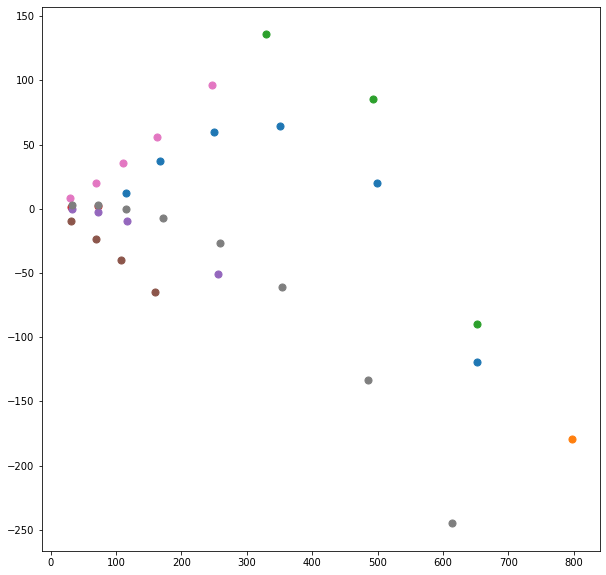

In [8]:
plt.figure(figsize=(10,10))
for pid in np.unique(hits[:,4])[1170:1180]:
    pid_hits = hits[hits[:,4] == pid]
    x = pid_hits[:,0] * np.cos(pid_hits[:,1])
    y = pid_hits[:,0] * np.sin(pid_hits[:,1])
    plt.scatter(x, y, s=50)

Where our Brian is the grey track above.

[[4132 4133 4134]
 [4133 4134 4135]]
CPU times: user 26.8 s, sys: 879 ms, total: 27.7 s
Wall time: 27.6 s


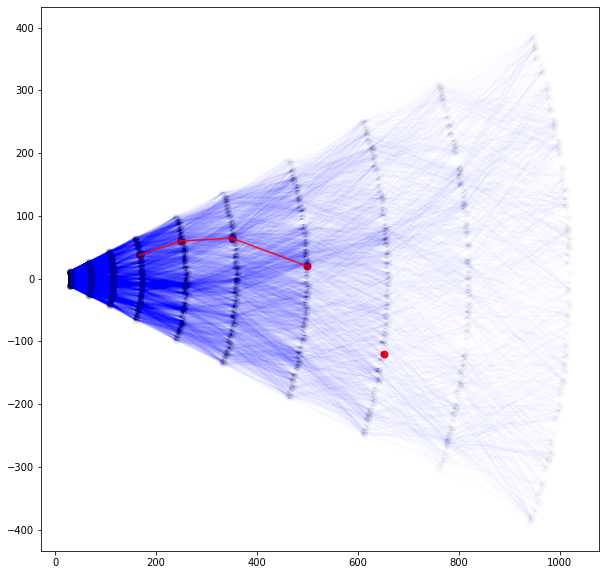

In [11]:
%%time
plot_brian(g1, feature_scale, brian, r_min = 0, r_max=1400)

[]
CPU times: user 29.9 s, sys: 776 ms, total: 30.7 s
Wall time: 30.7 s


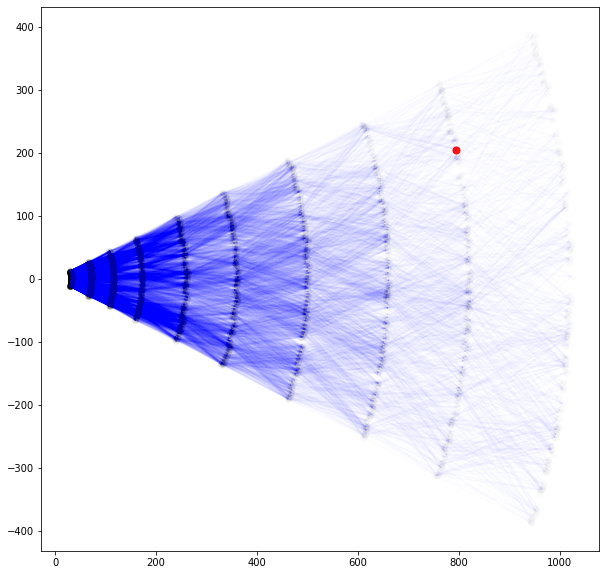

In [10]:
%%time
plot_brian(g2, feature_scale, brian, r_min = 0, r_max=1400)

Clearly, the heuristic construction didn't nail Brian. Even before classification, he is only half constructed, split between graphs and with some hits too far from each other to connect with doublets.

## Embedding Construction

We will load graphs constructed using an Adjacent Embedding (AE) model. That is, the embedding is trained on hits from adjacent layers, but may not necessarily construct edges only between adjacent layers. Let's examine what it gives us.

In [58]:
AE_input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/processed_sparse/adjacent/graphs"
all_events = os.listdir(AE_input_dir)
all_events = [os.path.join(AE_input_dir, event) for event in all_events]
all_events.sort()

In [61]:
%%time
train_size, test_size = 1, 1
out = display(progress(0, train_size), display_id=True)
AE_train_dataset = [prepare_AE_event(event, feature_names, feature_scale, pt_min, n_phi_sections, iter, train_size, out) for (iter, event) in enumerate(all_events[:train_size])]
AE_train_dataset = [datapoint for dataset in AE_train_dataset for datapoint in dataset]
out = display(progress(0, test_size), display_id=True)
AE_test_dataset = [prepare_AE_event(event, feature_names, feature_scale, pt_min, n_phi_sections, iter, test_size, out) for (iter, event) in enumerate(all_events[-test_size:])]
AE_test_dataset = [datapoint for dataset in AE_test_dataset for datapoint in dataset]
AE_train_loader = DataLoader(AE_train_dataset, batch_size=2, shuffle=True)
AE_test_loader = DataLoader(AE_test_dataset, batch_size=2, shuffle=True)

CPU times: user 929 ms, sys: 528 ms, total: 1.46 s
Wall time: 1.05 s


In [64]:
g1 = AE_test_loader.dataset[7]
g2 = AE_test_loader.dataset[6]
X = g1.x.numpy() * feature_scale
hits = np.vstack([X.T, g1.I.numpy(), g1.pid.numpy()]).T
sum(hits[:,4] == brian)

10

In [75]:
g1.edge_index.shape

torch.Size([2, 24483])

In [77]:
sum(g1.y)

tensor(4750.)

Where is Brian:

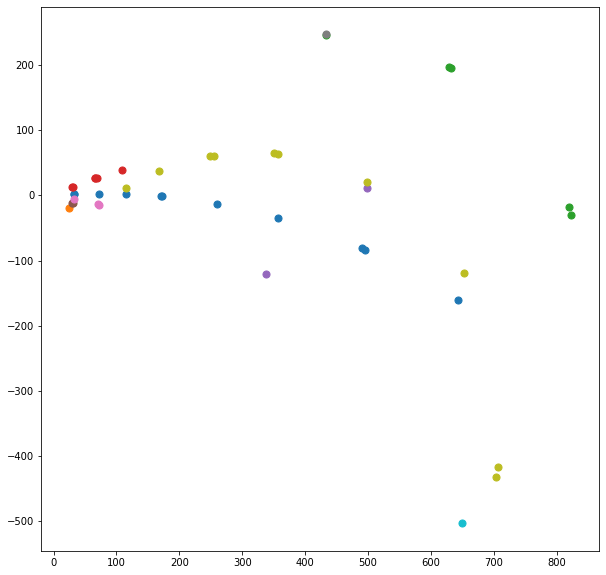

In [19]:
plt.figure(figsize=(10,10))
for pid in np.unique(hits[:,4])[1320:1330]:
    pid_hits = hits[hits[:,4] == pid]
    x = pid_hits[:,0] * np.cos(pid_hits[:,1])
    y = pid_hits[:,0] * np.sin(pid_hits[:,1])
    plt.scatter(x, y, s=50)

Our friend should be recognisable as the green track. The entire track is in this event, which is encouraging - it means that the embedding thought the edges connecting the two furthest hits were likely even though the hits were outside of the naive division of the event. A visualisation will help:

[[5806 1316 1316 3766 3770 3766 3770 5534 5538  648]
 [1316 3766 3770 5534 5534 5538 5538  648  648 2364]]
CPU times: user 12.4 s, sys: 328 ms, total: 12.7 s
Wall time: 12.7 s


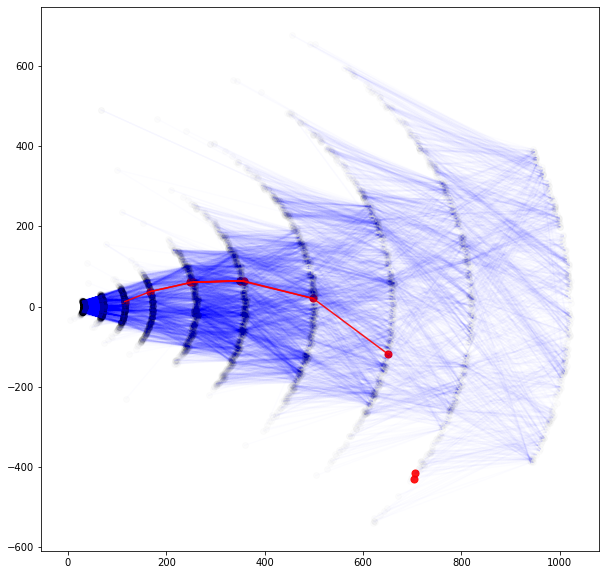

In [12]:
%%time
plot_brian(g1, feature_scale, brian)

Observe that Brian was not connected in this graph because we (arbitrarily) choose to not connect **outside** the graph split heading outwards, only inwards. We can examine this decision later... For now, look at the other graph containing Brian.

In [ ]:
%%time
plot_brian(g2, feature_scale, brian)

[[2635 2635]
 [3834 4207]]


A lot to unpack here. A) There are some self-edges. They will be removed by the recent push, I hope. There are also doublets between hits on the same layer. 

### Edge Distributions

In [34]:
HC_data = HC_test_loader.dataset[0]
HC_e, HC_X = HC_data['edge_index'].numpy(), HC_data['x'].numpy()*feature_scale

In [35]:
AE_data = AE_test_loader.dataset[0]
AE_e, AE_X = AE_data['edge_index'].numpy(), AE_data['x'].numpy()*feature_scale

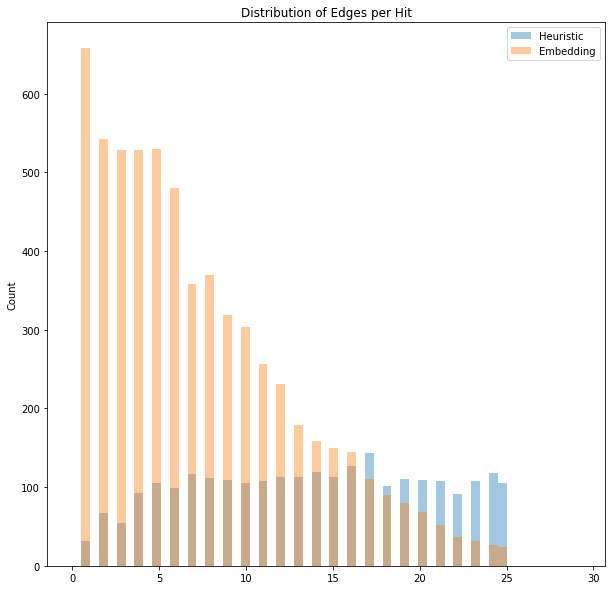

In [36]:
plt.figure(figsize=(10,10))
ax = sns.distplot(list(Counter(np.hstack([HC_e[0,:], HC_e[1,:]])).values()), kde=False, label="Heuristic", bins=np.linspace(0, 25))
ax = sns.distplot(list(Counter(np.hstack([AE_e[0,:], AE_e[1,:]])).values()), kde=False, label="Embedding", bins=np.linspace(0, 25))
# ax = sns.distplot(list(Counter(np.hstack([AAE_e[0,:], AAE_e[1,:]])).values()), kde=False, label="Augmented Embedding", bins=np.linspace(0, 25))
ax.set(ylabel='Count')
ax.legend()
ax.set_title("Distribution of Edges per Hit")
plt.show()

Clearly, there is a different topology for the two graphs. The "small world"-ness of the heuristic graph is much greater than the embedded graph: Messages can be passed around much more freely.

### A different choice of connecting inter-graph

Let's try constructing the track by keeping **all** connecting edges between graphs.

In [20]:
%%time
train_size, test_size = 1, 1
out = display(progress(0, train_size), display_id=True)
AE_train_dataset = [prepare_AE_event(event, feature_names, feature_scale, pt_min, n_phi_sections, iter, train_size, out, fully_connected=True) for (iter, event) in enumerate(all_events[:train_size])]
AE_train_dataset = [datapoint for dataset in AE_train_dataset for datapoint in dataset]
out = display(progress(0, test_size), display_id=True)
AE_test_dataset = [prepare_AE_event(event, feature_names, feature_scale, pt_min, n_phi_sections, iter, test_size, out, fully_connected=True) for (iter, event) in enumerate(all_events[-test_size:])]
AE_test_dataset = [datapoint for dataset in AE_test_dataset for datapoint in dataset]
AE_train_loader = DataLoader(AE_train_dataset, batch_size=2, shuffle=True)
AE_test_loader = DataLoader(AE_test_dataset, batch_size=2, shuffle=True)

CPU times: user 2.25 s, sys: 196 ms, total: 2.44 s
Wall time: 1.69 s


In [21]:
g1 = AE_test_loader.dataset[7]
g2 = AE_test_loader.dataset[6]
X = g1.x.numpy() * feature_scale
hits = np.vstack([X.T, g1.I.numpy(), g1.pid.numpy()]).T
sum(hits[:,4] == brian)

10

Finding Brian

In [22]:
np.where(np.unique(hits[:,4])==brian)

(array([1458]),)

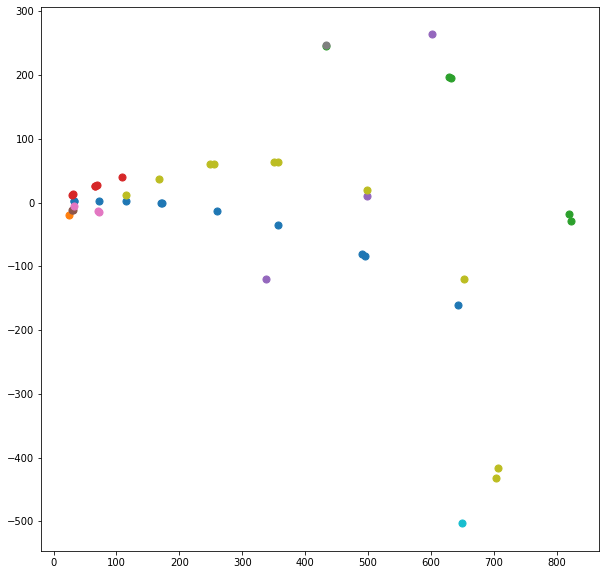

In [23]:
plt.figure(figsize=(10,10))
for pid in np.unique(hits[:,4])[1450:1460]:
    pid_hits = hits[hits[:,4] == pid]
    x = pid_hits[:,0] * np.cos(pid_hits[:,1])
    y = pid_hits[:,0] * np.sin(pid_hits[:,1])
    plt.scatter(x, y, s=50)

Our friend should be recognisable as the green track. The entire track is in this event, which is encouraging - it means that the embedding thought the edges connecting the two furthest hits were likely even though the hits were outside of the naive division of the event. A visualisation will help:

[[4005 4786 4786 5617 5621 5617 5621 6433 6437  433 1688 1688]
 [4786 5617 5621 6433 6433 6437 6437  433  433 1688 2581 2582]]
CPU times: user 15.2 s, sys: 622 ms, total: 15.8 s
Wall time: 15.8 s


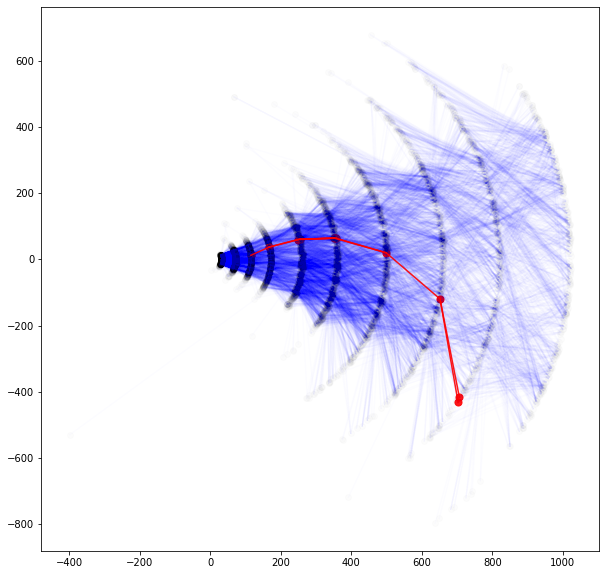

In [11]:
%%time
plot_brian(g1, feature_scale, brian)

And now, Brian is fully covered by this graph. We got a little lucky, in that he fits on one eighth of the graph, given how much curvature the track has. 

[[1873 1873]
 [2691 2692]]
CPU times: user 14.9 s, sys: 427 ms, total: 15.3 s
Wall time: 15.3 s


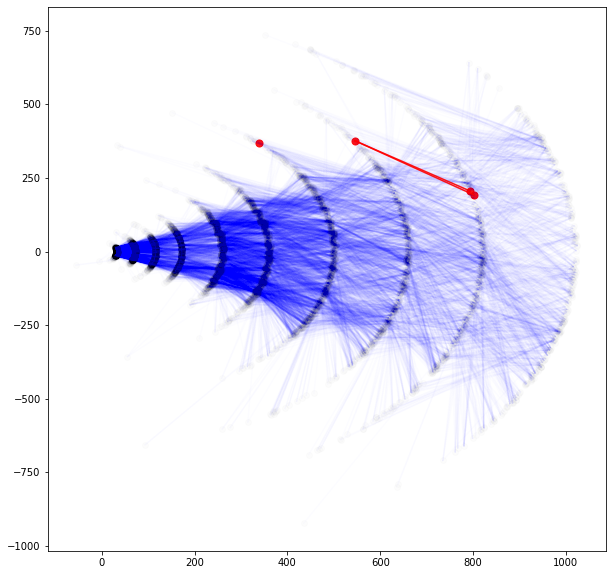

In [12]:
%%time
plot_brian(g2, feature_scale, brian)

### Edge Distributions

In [39]:
HC_data = HC_test_loader.dataset[0]
HC_e, HC_X = HC_data['edge_index'].numpy(), HC_data['x'].numpy()*feature_scale

In [40]:
AE_data = AE_test_loader.dataset[0]
AE_e, AE_X = AE_data['edge_index'].numpy(), AE_data['x'].numpy()*feature_scale

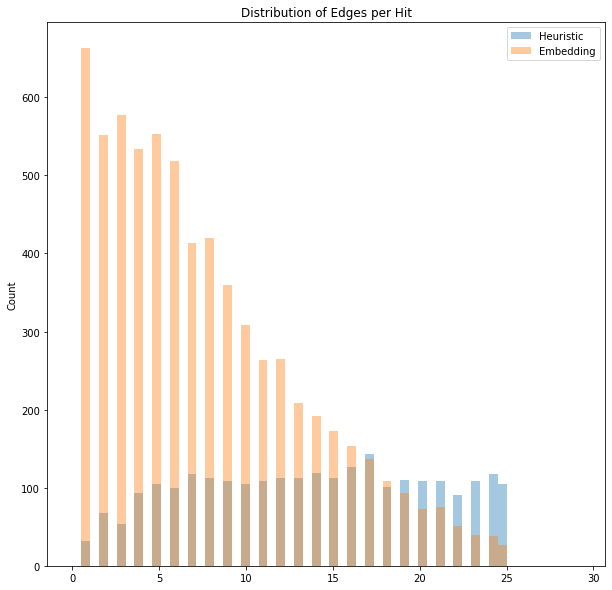

In [41]:
plt.figure(figsize=(10,10))
ax = sns.distplot(list(Counter(np.hstack([HC_e[0,:], HC_e[1,:]])).values()), kde=False, label="Heuristic", bins=np.linspace(0, 25))
ax = sns.distplot(list(Counter(np.hstack([AE_e[0,:], AE_e[1,:]])).values()), kde=False, label="Embedding", bins=np.linspace(0, 25))
# ax = sns.distplot(list(Counter(np.hstack([AAE_e[0,:], AAE_e[1,:]])).values()), kde=False, label="Augmented Embedding", bins=np.linspace(0, 25))
ax.set(ylabel='Count')
ax.legend()
ax.set_title("Distribution of Edges per Hit")
plt.show()

Note that with this choice of split, the edge distribution is shifted to the right. That's good - more edges per hit let the GNN pass messages better.